<a href="https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
3.    py3Dmol (https://pypi.org/project/py3Dmol/)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer

conda install -c conda-forge ambertools

conda install -c ambermd pytraj 

conda install -c conda-forge biopandas

conda install -c conda-forge mdanalysis

conda install -c conda-forge py3dmol

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj

conda install -c conda-forge nglview



In [1]:
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#load dependencies

import os
import sys
from simtk import openmm as mm

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

import numpy as np
import py3Dmol

#import pytraj as pt
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import seaborn as sb
from statistics import mean, stdev
#from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import MDAnalysis as mda
import mdtraj as md


In [3]:
from __future__ import print_function
from IPython.display import set_matplotlib_formats


In [4]:
from simtk import unit
from openmm import app

datadir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/'
workDir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/outdir/'
initial_pdb='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb'
force_field='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb
/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.xml


In [5]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017486 kJ/mol


In [6]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,27.93112833712634,260.57287420466463
200,26.377411124744917,334.9779543090931
300,37.49438321240539,257.051719049013
400,49.30638429888083,314.05421621325235
500,41.335339436555515,340.90761867038
600,34.25576129430046,399.66081449900827
700,33.947909058592614,287.0752754585866
800,43.1860768646098,269.6965920840614
900,69.37801778372067,217.80572952417253
1000,58.53487871362621,356.4770719176179
1100,46.902958185741184,369.93746527934826
1200,44.672060696765826,391.46513750575764
1300,30.045586201938164,288.58986056502107
1400,49.779393853054565,411.2760219279639
1500,82.90516008402622,261.8928279344096
1600,45.47884773586482,458.3976017337794
1700,45.251689378143844,264.51967852897667
1800,48.887263989880935,219.98898899269244
1900,22.278544105004443,426.5179099659187
2000,27.800634427733378,263.9941397587471
2100,49.888993510615464,241.21678260964458
2200,56.075494946401015,357.68487428494194
2300,35.2377356

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,34.473065026162175,209.4342673906664,0
500000,999.9999999901769,33.54849338619964,342.03331063614183,1.81e+04
750000,1499.9999999783536,28.99010596324007,406.6997411664402,1.81e+04
1000000,1999.9999999665301,30.99772997432319,259.7461717285258,1.77e+04
Done!
Time required for simulation: 9.687441110610962 seconds


In [8]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
traj
#traj.superpose(ref)

<mdtraj.Trajectory with 10000 frames, 14 atoms, 1 residues, without unitcells at 0x7f804c9b8e50>

In [9]:
#jupyter-nbextension enable --py --user nglview
#jupyter-nbextension enable --py --user widgetsnbextension 

import ipywidgets
from ipywidgets import interact, fixed
import warnings
import nglview as ngl
from nglview.player import TrajectoryPlayer
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

In [10]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [11]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x7f804fa46cd0>

In [12]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


**Class Activity - Plot the Harmonic Bond Force Field Term for a C-C Bond**

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html

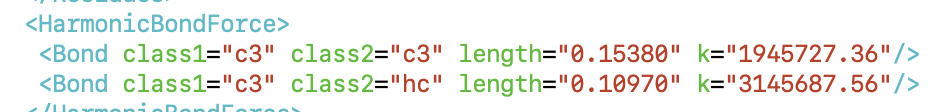

In [13]:
#Compute Some Distances and plot the time course - Bond 0-4
bond_indices = [0, 4] 


In [14]:
#Compute Some Distances and plot the time course - Bond 0-4

bond_indices = [4, 7] 


In [15]:
#Compute Some Distances and plot the time course - Bond 0-4
bond_indices = [7, 10] 


In [16]:
#Plot Histograms of Each Bond Length



Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

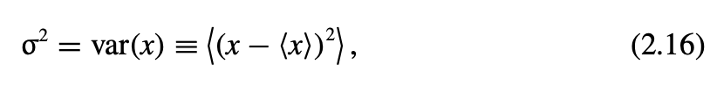

In [687]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [17]:
###SOLUTION###


In [18]:
#Lets Check Our Answers with the Built In Numpy Libraries np.var and np.std


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [20]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

#plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',linewidth=0.05)
#######SOLUTION###########



**Homework Question:  Why does one pair of these bonds appear more correlated than the other?**

***Class Activity*** 

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

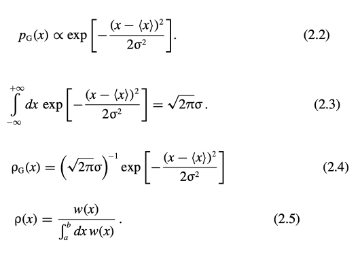
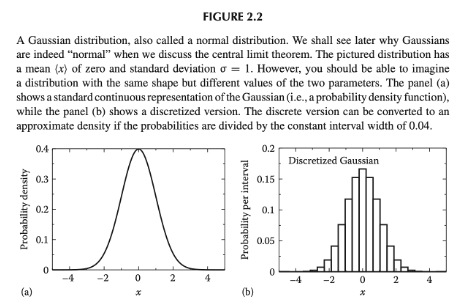

In [22]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit



#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 




***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

In [23]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####SOLUTION####


**Homework Problem #2: convert these probability distributions to culmulative distribution functions**

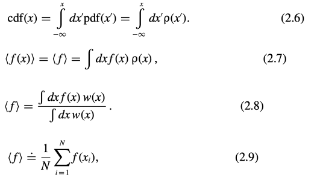

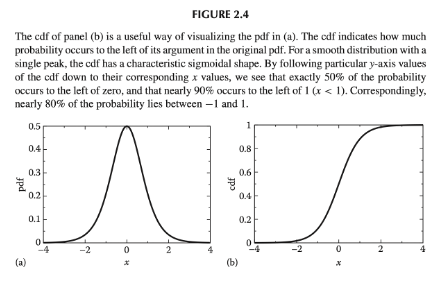

In [521]:
#ADD CODE FOR CDFs HERE#

**Homework Problem #3: Lets draw some different some random frames from our trajectory (for example 10,100, and 1000),  calculate the probability distribution functions for 5 of these random samples, and fit  gaussians to these probability distirbution functions***
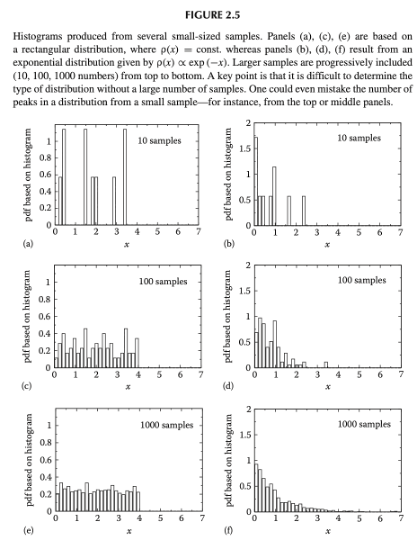

In [24]:
#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands


array([9680,  786, 2670, 9181, 2808, 5672, 7241, 8751, 1813, 9461])

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a good way to visualize the C-C-C-C dihedral angle 

In [25]:
#Lets Compute Some Bond Angles 
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
#ang=np.degrees(angle_rad)




***Homework Challenge Question:  Can you estimate the lifetime of the higher energy C-C-C-C dihedral states?*****

In [737]:
####Challenge Question Can you estimate the lifetime of the higher energy C-C-C-C dihedral states####

**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

In [26]:
#Are the bond angle and dihedral correlated?



#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])


**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

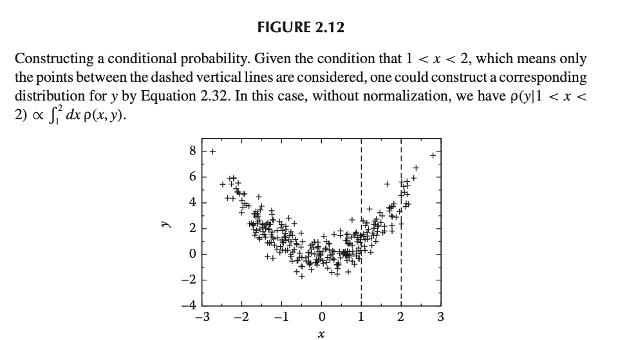

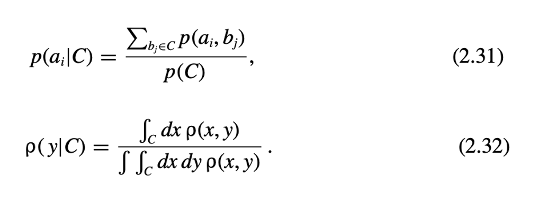

In [ ]:
#Homework problem 3##

**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

[0.00000000e+00 2.00020002e+00 4.00040004e+00 ... 1.99959996e+04
 1.99979998e+04 2.00000000e+04]


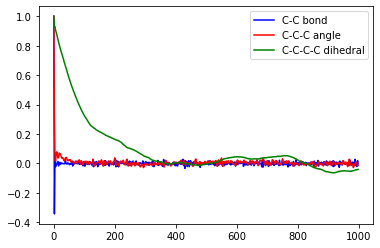

In [636]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

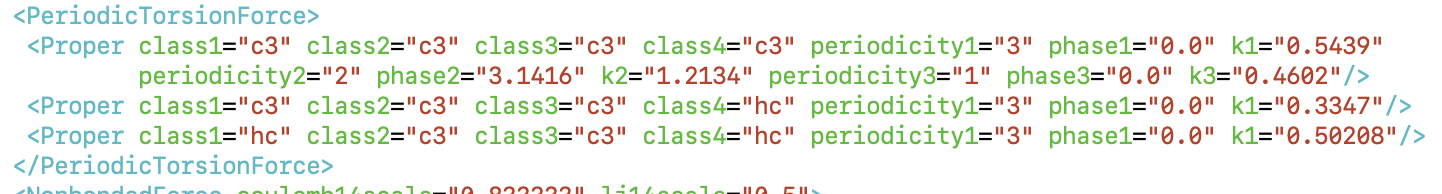

In [27]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets right a function that takes paramters from the xml and writes the force field term


In [774]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [28]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)



**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

In [29]:
####Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]


#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]


In [30]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
#diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]


In [31]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME

#plt.scatter(CCCH_torsions[:,0],CCCH_E[:,0])


In [32]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies



Plot The Total Torsion Energy As a Function of the C-C-C-C Dihedral Angle - Compare your plot Energetic Torsion Barriers from Cramer.  How Can you explain the Difference?

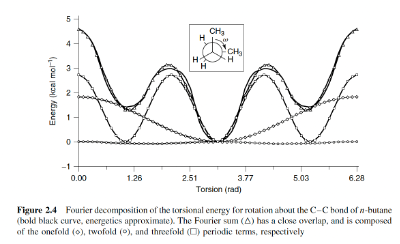

In [33]:
#Solution


***Homework Problem #6: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [34]:
###SOLUTION#####


***Homework Problem #7: Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

**Homework Problem #8:  Calculate LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

**Challenge Problem:  Atempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?**


**Challenge Problem #2:  Attempt to calculate all Coulumb interactions for a frame and all frames**

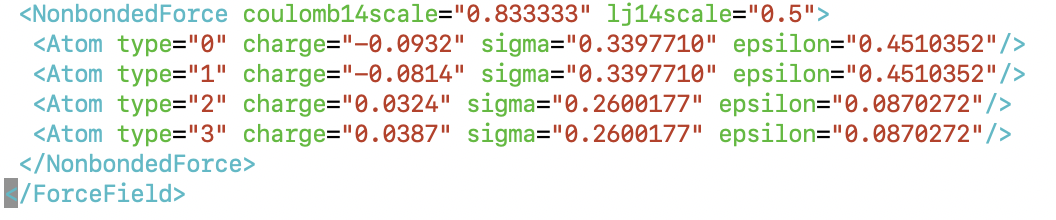




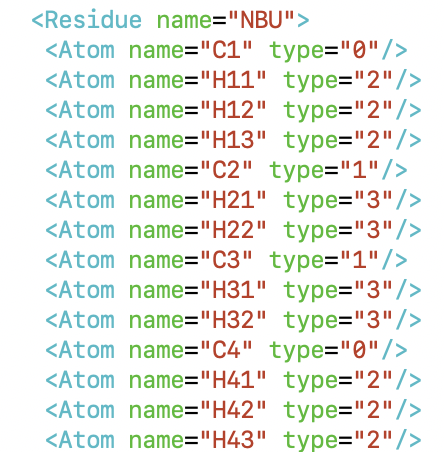

In [ ]:
#Calculate LJ and Couloumb Potentionals Here

***Having fun with small molecule simulations?  Why not simulate a new molecule that you think might be interesting***

You can install a conda package that lets you generate a molecular structure and force field from a SMILES string:

conda install --yes -c conda-forge openmmforcefields
conda install -c conda-forge openff-toolkit    

And you can find the documentation to generate a structure and force field for a compound here
https://github.com/openmm/openmmforcefields

You can draw a structure here and convert it to a SMILES string and download and sdf file to build an openMM system here: 

http://www.cheminfo.org/Chemistry/Cheminformatics/FormatConverter/index.html

